<style>
/* Set font size for headers */
h1, h2, h3, h4, h5, h6 {
    font-size: 32px; /* Adjust as needed */
}

/* Set font size for paragraphs */
p, li, ul {
    font-size: 24px; /* Adjust as needed */
}
</style>


Introduction to the Julia programming language

![](images/julia-logo.svg)

## 19 Machine learning

We use the simulated data from the [MAGIC telescope](https://en.wikipedia.org/wiki/MAGIC_(telescope).

The MAGIC telescope is a Cherenkov telescope situated on La Palma, one of the Canary Islands. The [MAGIC machine learning dataset](https://archive.ics.uci.edu/ml/datasets/magic+gamma+telescope) can be obtained from [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

Our task is to separate signal events (gamma showers) and background events (hadron showers) based on the features of a measured Cherenkov shower.

## Classification of air showers
![](images/magic_overview.png)

## Features of the measured air showers
![](images/magic_variables.png)



The features of a shower are:

    1.  fLength:  continuous  # major axis of ellipse [mm]
    2.  fWidth:   continuous  # minor axis of ellipse [mm] 
    3.  fSize:    continuous  # 10-log of sum of content of all pixels [in #phot]
    4.  fConc:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
    5.  fConc1:   continuous  # ratio of highest pixel over fSize  [ratio]
    6.  fAsym:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
    7.  fM3Long:  continuous  # 3rd root of third moment along major axis  [mm] 
    8.  fM3Trans: continuous  # 3rd root of third moment along minor axis  [mm]
    9.  fAlpha:   continuous  # angle of major axis with vector to origin [deg]
    10. fDist:    continuous  # distance from origin to center of ellipse [mm]
    11. class:    g,h         # gamma (signal), hadron (background)

g = gamma (signal):     12332
h = hadron (background): 6688

For technical reasons, the number of h events is underestimated.
In the real data, the h class represents the majority of the events.

In [68]:
using CSV, DataFrames, XGBoost, MLUtils, Plots
ENV["DATAFRAMES_ROWS"] = 10;

In [60]:
magic_data = CSV.read(joinpath("data", "magic04_data.txt"), DataFrame)
magic_data.class = (l -> l == "g" ? 1 : 0).(magic_data.class)
magic_data

Row,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.011,-8.2027,40.092,81.8828,1
2,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.261,1
3,162.052,136.031,4.0612,0.0374,0.0187,116.741,-64.858,-45.216,76.96,256.788,1
4,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.449,116.737,1
5,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.648,356.462,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
19016,21.3846,10.917,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.826,0
19017,28.9452,6.702,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.456,0
19018,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.517,0


In [61]:
# y = value to predict, X = features
# Convert DataFrame to tuple of arrays
X = Matrix(magic_data[:, 1:end-1])  # Features
y = magic_data[:, :class];          # Target

In [62]:
# Shuffle observations
shuffled_indices = shuffleobs(1:size(X, 1))  # Shuffle row indices
X_shuffled = X[shuffled_indices, :]
y_shuffled = y[shuffled_indices, :];

In [63]:
# Split shuffled data into training and test sets
train_indices, test_indices = splitobs(1:size(X, 1), at = 0.8)  # 80% training, 20% testing

train_X = X_shuffled[train_indices, :]
train_y = vec(y_shuffled[train_indices, :])
test_X = X_shuffled[test_indices, :]
test_y = vec(y_shuffled[test_indices, :]);

In [64]:
bst = xgboost((train_X, train_y), num_round=1000, objective="binary:logistic")

┌ Info: XGBoost: starting training.
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:601
┌ Info: [1]	train-logloss:0.51956359457643753
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:451
┌ Info: [2]	train-logloss:0.44740669651017706
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:451
┌ Info: [3]	train-logloss:0.40093029424211268
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:451
┌ Info: [4]	train-logloss:0.37051638516721824
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:451
┌ Info: [5]	train-logloss:0.34895901042981747
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:451
┌ Info: [6]	train-logloss:0.33125522034389643
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:451
┌ Info: [7]	train-logloss:0.31531377211869249
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:451
┌ Info: [8]	train-logloss:0.304467

Booster()

In [65]:
# Evaluate model on test data
predictions = predict(bst, test_X);

a) Plot predicted probabilities for the test sample for signal and background events:

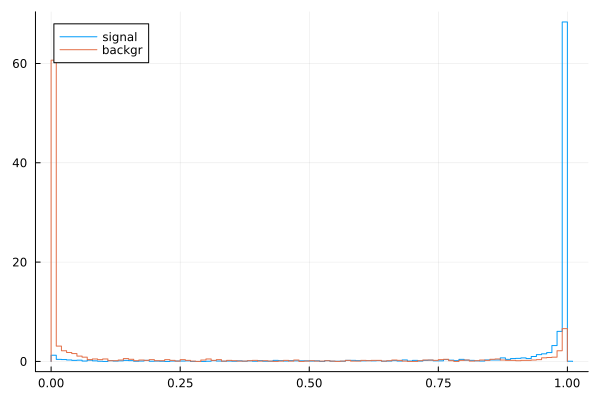

In [66]:
signal_indicees = findall(test_y .== 1);
backgr_indecees = findall(test_y .!= 1);

stephist(predictions[signal_indicees], normalize=true, label="signal", bins=100)
stephist!(predictions[backgr_indecees], normalize=true, label="backgr", bins=100)

In [67]:
# Calculate evaluation metric (e.g., accuracy)
threshold = 0.8
predicted_labels = Int64.(predictions .> threshold)
accuracy = sum(predicted_labels .== test_y) / length(test_y)
println("accuracy = $(accuracy)")

accuracy = 0.8719768664563617
